# Compare sea surface height model output and observations

Comparing the sea-surface height (ssh) from two different resolution runs. Specifically, we plot the time-mean and standard deviation of ssh and compare it to those obtained from observations from the CMEMS satellite altimetry dataset (former AVISO+ dataset).

In [1]:
from dask.distributed import Client

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43523,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 188.56 GiB
Comm: tcp://127.0.0.1:46679,Total threads: 6
Dashboard: /proxy/42433/status,Memory: 23.57 GiB
Nanny: tcp://127.0.0.1:45149,


#### SSH variable in ACCESS-OM2 models
We select only 60 years of monthly data in models in this example. But you can probably extend up to middle of 2020 for observations.

## SSH from 1$^{\circ}$ and 0.25$^{\circ}$ model output

In [1]:
from esmvalcore.dataset import Dataset
model_datasets = {
"ACCESS-OM2": 
    Dataset(
    short_name='zos',
    project='CMIP6',
    activity='OMIP',
    mip="Omon",
    exp="omip2",
    ensemble="r1i1p1f1",
    timerange="0306/0366",
    dataset="ACCESS-OM2",
    grid="gn"
),
"ACCESS-OM2-025": 
    Dataset(
    short_name='zos',
    project='CMIP6',
    activity='OMIP',
    mip="Omon",
    exp="omip2",
    ensemble="r1i1p1f1",
    timerange="0306/0366",
    dataset="ACCESS-OM2-025",
    grid="gn"
)}

In [33]:
# model_datasets["ACCESS-OM2"].load()

## CMEMS satellite observational data (former AVISO+ dataset)

CMORised with ESMValTool

In [2]:
from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2')

obs = {"CMEMS": Dataset(dataset= 'CMEMS', project= 'OBS6', 
              type= '*', 
              timerange='1993/2023', 
              tier='2', 
              mip='Omon', short_name='zos')
      }


In [3]:
## preprocessers
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import regrid

def mean_std(cube):
    m_cube = climate_statistics(cube, period="full", operator="mean")
    std_cube = climate_statistics(cube, period="full", operator="std_dev")
    return m_cube, std_cube

# for model regrid linear according to degree resolution "ACCESS-OM2-025"

In [15]:
# obs_cube = obs.load()
data_res = {}
for name, ds in {**model_datasets,**obs}.items():
    cubes = mean_std(ds.load())
    if name == "ACCESS-OM2":
        regrid_cubes = [regrid(cube, target_grid="1x1", scheme="linear") for cube in cubes]
    elif name == "ACCESS-OM2-025":
        regrid_cubes = [regrid(cube, target_grid="0.25x0.25", scheme="linear") for cube in cubes] #0.25,0.25 for 0.25deg
    else:
        regrid_cubes = cubes
    data_res[name] = regrid_cubes

data_res

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(

{'ACCESS-OM2': [<iris 'Cube' of sea_surface_height_above_geoid / (m) (latitude: 180; longitude: 360)>,
  <iris 'Cube' of sea_surface_height_above_geoid / (m) (latitude: 180; longitude: 360)>],
 'ACCESS-OM2-025': [<iris 'Cube' of sea_surface_height_above_geoid / (m) (latitude: 720; longitude: 1440)>,
  <iris 'Cube' of sea_surface_height_above_geoid / (m) (latitude: 720; longitude: 1440)>],
 'CMEMS': (<iris 'Cube' of sea_surface_height_above_geoid / (m) (latitude: 1440; longitude: 2880)>,
  <iris 'Cube' of sea_surface_height_above_geoid / (m) (latitude: 1440; longitude: 2880)>)}

In [16]:
data_res['ACCESS-OM2'][0]

<iris 'Cube' of sea_surface_height_above_geoid / (m) (latitude: 180; longitude: 360)>

## Plot and compare

In [20]:
import iris.plot as iplt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean as cm
import numpy as np



Plot the time-mean and standard deviation of both of the model outputs and the CMEMS observational dataset (former AVISO+).

0 ACCESS-OM2 RdBu_r
0 ACCESS-OM2-025 RdBu_r
0 CMEMS RdBu_r
1 ACCESS-OM2 YlGnBu
1 ACCESS-OM2-025 YlGnBu
1 CMEMS YlGnBu
CPU times: user 2min 13s, sys: 112 ms, total: 2min 13s
Wall time: 2min 13s


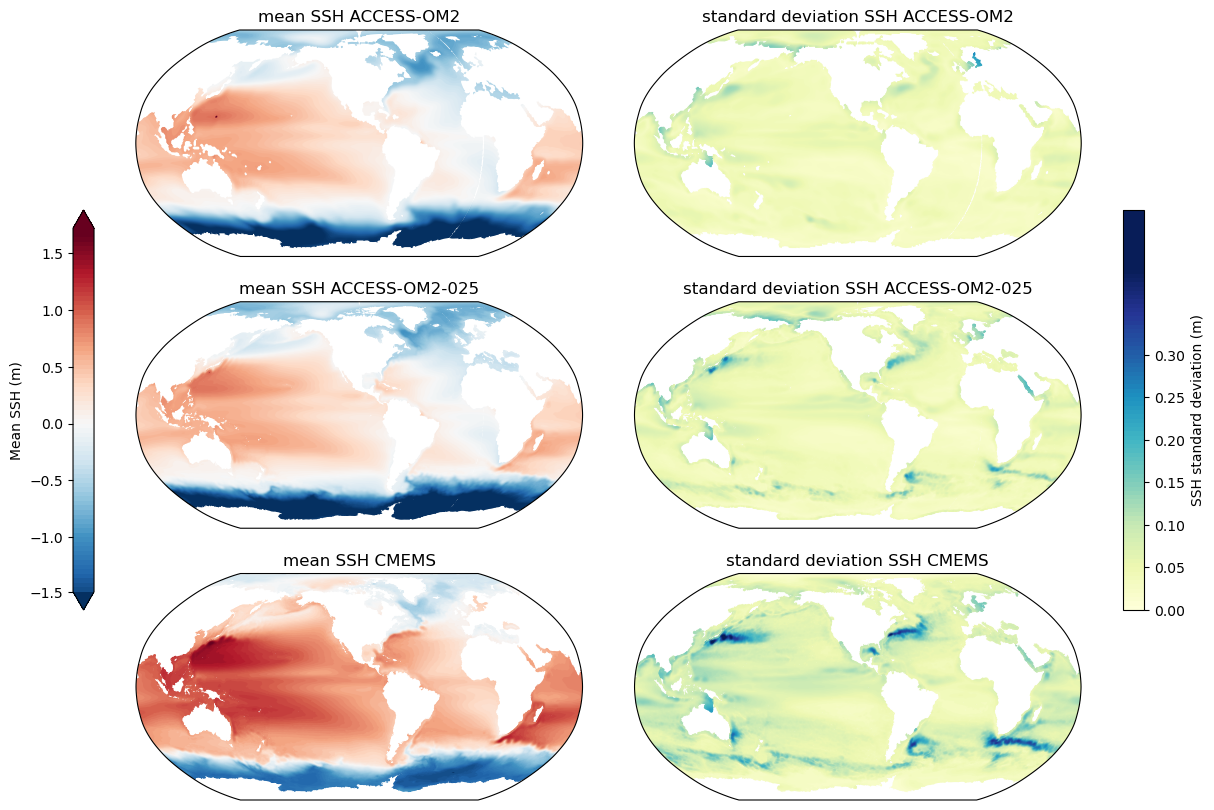

In [25]:
%%time

projection = ccrs.Robinson(central_longitude=-100)

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (14, 10),
                         subplot_kw={'projection': projection})
plt.subplots_adjust(wspace=-0.15)

max_std = 0.4
max_mean = 1.65
res = ['mean', 'standard deviation']
colmap = ['RdBu_r', 'YlGnBu']

for c, max_val in enumerate([max_mean, max_std]): #[0,1]: #mean, std

    for n, dataset in enumerate(data_res): #[0,1,2]: # data/models

        minv = -max_val if c == 0 else 0
        ext_val = 'both' if c == 0 else 'max'
        ax = axes[n,c]
        print(c, dataset, colmap[c])
        p1 = iplt.contourf(data_res[dataset][c],
                           axes=ax,
                           levels=100, 
                           vmin = minv,
                           vmax = max_val,
                           extend= ext_val, #max for std
                           cmap=colmap[c])
        ax.set_title(f'{res[c]} SSH {dataset}')
        if c == 0: # get for colourbar of mean done first
            p0 = p1

# Colorbars
ax_cb1 = plt.axes([0.13, 0.3, 0.015, 0.4])
cb = plt.colorbar(p0, cax=ax_cb1, extend='both', label='Mean SSH (m)', ticks=np.arange(-1.5,1.6,0.5))
ax_cb1.yaxis.set_ticks_position('left')
ax_cb1.yaxis.set_label_position('left')

ax_cb2 = plt.axes([0.88, 0.3, 0.015, 0.4]) #levels=np.arange(0,10,0.2) ticks=np.arange(0,10,1)
cb = plt.colorbar(p1, cax=ax_cb2, label='SSH standard deviation (m)', ticks=np.arange(0,0.35,0.05))

In [14]:
client.close()